原文来自：https://hml.boyuai.com/books/chapter6  
这部分建议仔细读原文，里面对于数学分析和理论讲得比较清楚和详细。

所用的数据集 lr_dataset.csv 包含了二维平面上的一些点，这些点按位置的不同分为两类。每条样本依次包含横坐标、纵坐标和类别标签。我们的任务是训练逻辑斯谛回归模型，使模型对点的类别预测尽可能准确。  
首先，我们读入并处理数据集，并将其在平面上的分布展示出来。图中的每个红色圆圈代表一个正类，蓝色叉号代表一个负类。  

数据集大小： 1000


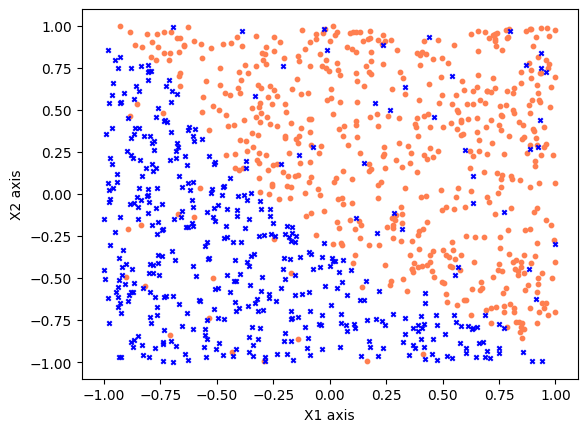

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 从源文件中读入数据并处理
lines = np.loadtxt('lr_dataset.csv', delimiter=',', dtype=float)
x_total = lines[:, 0:2]
y_total = lines[:, 2]
print('数据集大小：', len(x_total))

# 将得到的数据在二维平面上制图，不同的类别染上不同的颜色以便于观察样本点的分布
pos_index = np.where(y_total == 1)
neg_index = np.where(y_total == 0)
plt.scatter(x_total[pos_index, 0], x_total[pos_index, 1],
    marker='o', color='coral', s=10)
plt.scatter(x_total[neg_index, 0], x_total[neg_index, 1],
    marker='x', color='blue', s=10)
plt.xlabel('X1 axis')
plt.ylabel('X2 axis')
plt.show()

# 划分训练集与测试集
np.random.seed(0)
ratio = 0.7
split = int(len(x_total) * ratio)
idx = np.random.permutation(len(x_total))
x_total = x_total[idx]
y_total = y_total[idx]
x_train, y_train = x_total[:split], y_total[:split]
x_test, y_test = x_total[split:], y_total[split:]

接下来，我们实现上节中所描述的几个评价指标。这里选用准确率和 AUC 两种，其他评价指标留给读者自行实践。对于 AUC 以外的指标，我们需要样本的真实标签以及某个阈值下模型的预测标签。而 AUC 中已经包含了阈值变化，所以需要的是模型原始的预测概率。

In [2]:
def acc(y_true, y_pred):
    return np.mean(y_true == y_pred)

def auc(y_true, y_pred):
    # 按预测值从大到小排序，越靠前的样本预测正类概率越大
    idx = np.argsort(y_pred)[::-1]
    y_true = y_true[idx]
    y_pred = y_pred[idx]
    # 把y_pred中不重复的值当作阈值，依次计算FP样本和TP样本数量
    # 由于两个数组已经排序且位置对应，直接从前向后累加即可
    tp = np.cumsum(y_true)
    fp = np.cumsum(1 - y_true)
    tpr = tp / tp[-1]
    fpr = fp / fp[-1]
    # 依次枚举FPR，计算曲线下的面积
    # 方便起见，给FPR和TPR最开始添加(0,0)
    s = 0.0
    tpr = np.concatenate([[0], tpr])
    fpr = np.concatenate([[0], fpr])
    for i in range(1, len(fpr)):
        s += (fpr[i] - fpr[i - 1]) * tpr[i]
    return s

由于本章所用的数据集大小较小，我们不再每次取小批量进行迭代，而是直接用完整的训练集计算梯度。接下来，我们按照之前推导的梯度下降公式定义训练函数，并设置学习率和迭代次数，查看训练结果。除了训练曲线之外，我们还将模型参数表示的直线在平面上展示出来。在直线同一侧的点被模型判断成同一类。

In [4]:
# 逻辑斯谛函数
def logistic(z):
    return 1 / (1 + np.exp(-z))

def GD(num_steps, learning_rate, l2_coef):
    # 初始化模型参数
    theta = np.random.normal(size=(X.shape[1],))
    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    train_auc = []
    test_auc = []
    for i in range(num_steps):
        pred = logistic(X @ theta)
        grad = -X.T @ (y_train - pred) + l2_coef * theta
        theta -= learning_rate * grad
        # 记录损失函数
        train_loss = - y_train.T @ np.log(pred) \
                     - (1 - y_train).T @ np.log(1 - pred) \
                     + l2_coef * np.linalg.norm(theta) ** 2 / 2
        train_losses.append(train_loss / len(X))
        test_pred = logistic(X_test @ theta)
        test_loss = - y_test.T @ np.log(test_pred) \
                    - (1 - y_test).T @ np.log(1 - test_pred)
        test_losses.append(test_loss / len(X_test))
        # 记录各个评价指标，阈值采用0.5
        train_acc.append(acc(y_train, pred >= 0.5))
        test_acc.append(acc(y_test, test_pred >= 0.5))
        train_auc.append(auc(y_train, pred))
        test_auc.append(auc(y_test, test_pred))

    return theta, train_losses, test_losses, \
    train_acc, test_acc, train_auc, test_auc

最后，我们定义各个超参数，进行训练并绘制出训练损失、准确率和 AUC 随训练轮数的变化。
在机器学习和统计建模中，**超参数（Hyperparameters）** 是指那些在开始学习过程之前需要设置的参数，它们不能由模型自动学习得到。超参数对于控制训练过程的行为至关重要，它们通常影响模型的性能和能力。   
**超参数的特点：** 
不同于模型参数：模型参数是模型在训练过程中通过学习数据自动获得的，如线性回归中的权重。而超参数是手动设置的，用于帮助指导学习过程，如学习率或树的深度。  
需要事先设定：在训练模型之前，必须先定义超参数。这些设置可能基于经验或通过使用系统化的方法，如网格搜索（Grid Search）或随机搜索（Random Search）来优化。  
影响模型性能：合适的超参数设置可以显著提高模型的性能，而不恰当的设置可能导致模型表现不佳，如过拟合或欠拟合。  
**常见的超参数：**  
学习率：在许多优化算法中，学习率决定了模型参数调整的速度。过高可能导致模型不稳定，过低可能导致训练过程过慢。  
正则化项：如 L1、L2 正则化的强度，用于防止模型过拟合。  
网络架构：在神经网络中，网络的层数、每层的单元数等都是超参数。  
批大小（Batch size）：在批量训练时每个批次的样本数量。  
迭代次数（Epochs）：整个训练集用于训练模型的次数。  
树的深度：在决策树和基于树的模型（如随机森林、梯度提升树）中，树的最大深度。  
核函数：在支持向量机（SVM）中，核函数的选择。  
**超参数调优：**  
找到最优的超参数配置是一个挑战，通常需要使用系统化的调优方法。这些方法包括：  
网格搜索：系统地遍历多种超参数的组合。  
随机搜索：随机选择超参数，以探索更广泛的值域。  
贝叶斯优化：使用贝叶斯技术模型超参数的效果，以更智能地选择下一组超参数。  
自动化机器学习（AutoML）：使用算法自动寻找最佳的超参数。  

因为大家用的模型基础都是一样的。理解并正确设置超参数对于实现最佳的机器学习模型性能至关重要。  


In [ ]:
# 定义梯度下降迭代的次数，学习率，以及L2正则系数
num_steps = 250
learning_rate = 0.002
l2_coef = 1.0
np.random.seed(0)

### 训练模型

预测准确率： 0.8766666666666667
回归系数： [3.13501827 2.90998799 0.55095127]


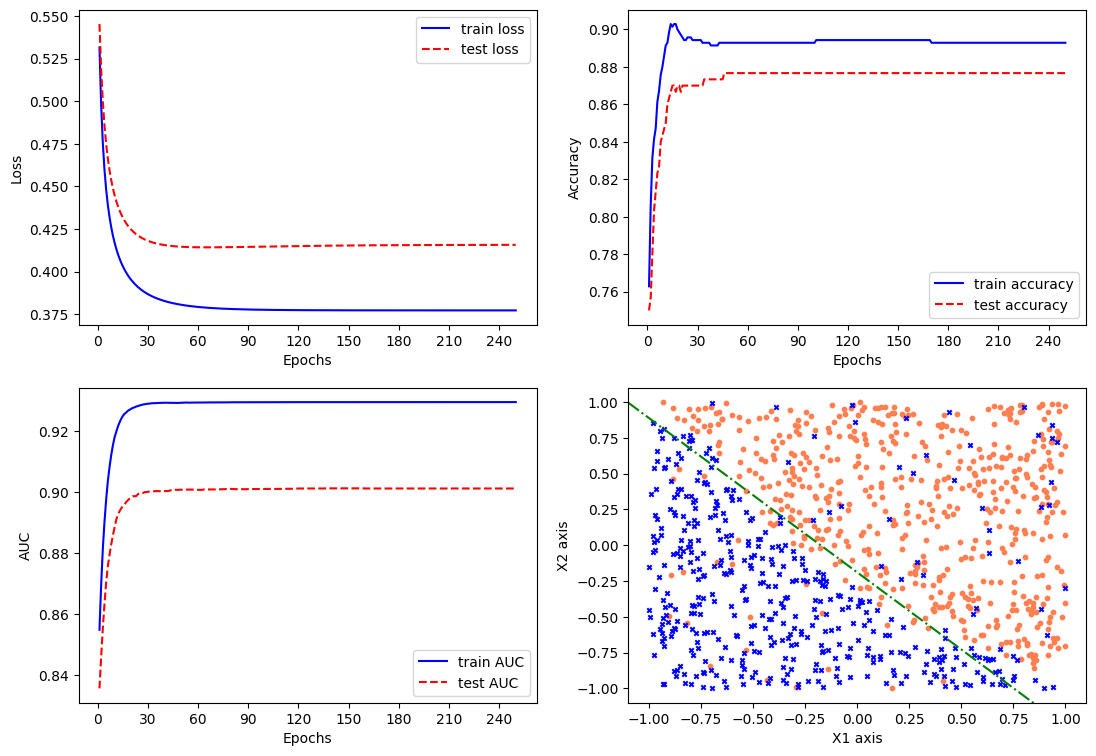

In [5]:
# 在x矩阵上拼接1
X = np.concatenate([x_train, np.ones((x_train.shape[0], 1))], axis=1)
X_test = np.concatenate([x_test, np.ones((x_test.shape[0], 1))], axis=1)

theta, train_losses, test_losses, train_acc, test_acc, \
    train_auc, test_auc = GD(num_steps, learning_rate, l2_coef)

# 计算测试集上的预测准确率
y_pred = np.where(logistic(X_test @ theta) >= 0.5, 1, 0)
final_acc = acc(y_test, y_pred)
print('预测准确率：', final_acc)
print('回归系数：', theta)

plt.figure(figsize=(13, 9))
xticks = np.arange(num_steps) + 1
# 绘制训练曲线
plt.subplot(221)
plt.plot(xticks, train_losses, color='blue', label='train loss')
plt.plot(xticks, test_losses, color='red', ls='--', label='test loss')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制准确率
plt.subplot(222)
plt.plot(xticks, train_acc, color='blue', label='train accuracy')
plt.plot(xticks, test_acc, color='red', ls='--', label='test accuracy')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 绘制AUC
plt.subplot(223)
plt.plot(xticks, train_auc, color='blue', label='train AUC')
plt.plot(xticks, test_auc, color='red', ls='--', label='test AUC')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

# 绘制模型学到的分隔直线
plt.subplot(224)
plot_x = np.linspace(-1.1, 1.1, 100)
# 直线方程：theta_0 * x_1 + theta_1 * x_2 + theta_2 = 0
plot_y = -(theta[0] * plot_x + theta[2]) / theta[1]
pos_index = np.where(y_total == 1)
neg_index = np.where(y_total == 0)
plt.scatter(x_total[pos_index, 0], x_total[pos_index, 1],
    marker='o', color='coral', s=10)
plt.scatter(x_total[neg_index, 0], x_total[neg_index, 1],
    marker='x', color='blue', s=10)
plt.plot(plot_x, plot_y, ls='-.', color='green')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel('X1 axis')
plt.ylabel('X2 axis')
plt.show()

为了进一步展示模型学到的概率信息，我们把模型预测的每个数据点的概率展示在下图的左半部分中，其中的轴和轴是数据点的坐标，轴是经过逻辑斯谛函数后模型预测的概率，绿色的平面是把分隔直线从二维伸展到三维的结果。样本点越靠上，说明模型预测该样本点属于正类的概率越大。可以看出，这些点分布出的曲面很像空间中逻辑斯谛函数的图像。事实上，如果沿着分隔平面的视角看过去，这些点恰好会组成逻辑斯谛函数的曲线，如图所示。这是因为逻辑斯谛回归模型给出的分类结果本质上还是概率结果，在分隔平面附近的点模型很难判断它们是正类还是负类，给出的概率接近 0.5；远离分隔平面的点模型比较有信心，给出的概率接近 0 或者 1。由于逻辑斯谛回归中线性预测部分是由逻辑斯谛函数映射为概率的，这些点的概率在空间中自然也就符合逻辑斯谛函数的曲线。

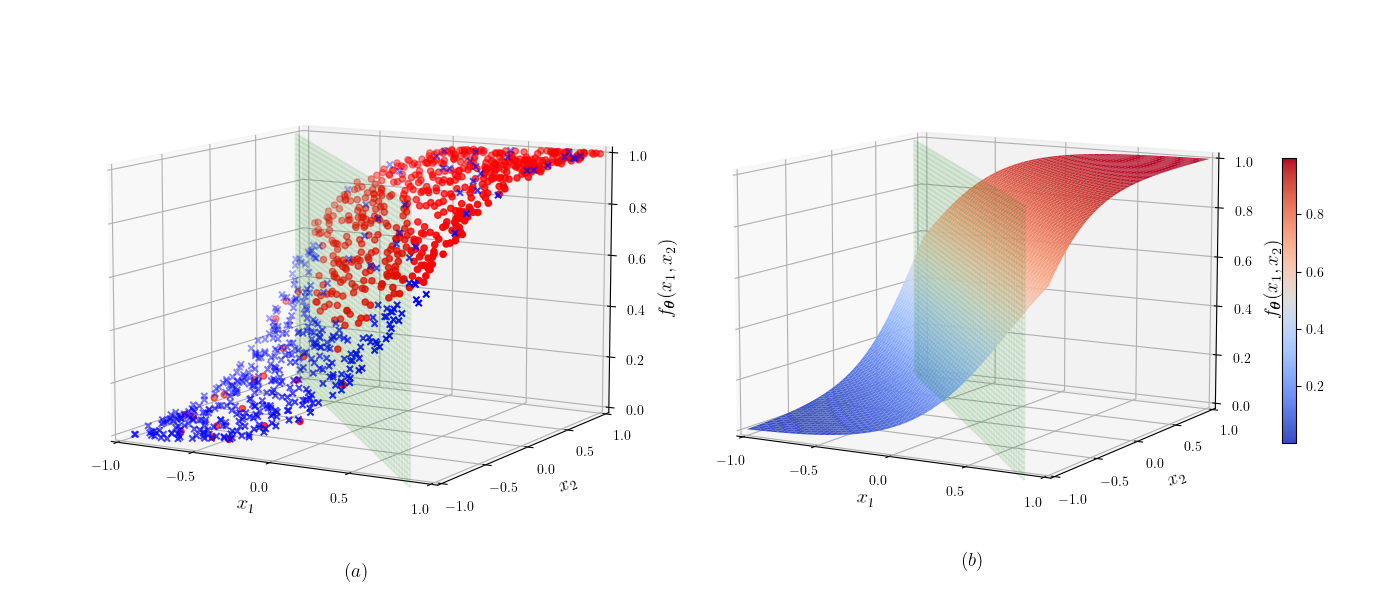


使用SKLearn的逻辑回归模型

In [6]:
from sklearn.linear_model import LogisticRegression

# 使用线性模型中的逻辑回归模型在数据集上训练
# 其提供的liblinear优化算法适合在较小数据集上使用
# 默认使用系数为1.0的L2正则化约束
# 其他可选参数请参考官方文档
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(x_train, y_train)
print('回归系数：', lr_clf.coef_[0], lr_clf.intercept_)

# 在数据集上用计算得到的逻辑回归模型进行预测并计算准确度
y_pred = lr_clf.predict(x_test)
print('准确率为：',np.mean(y_pred == y_test))

回归系数： [3.14129907 2.91620111] [0.5518978]
准确率为： 0.8766666666666667
